<a href="https://colab.research.google.com/github/simulai/TopoWMA/blob/main/TopoWMA_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision scikit-tda matplotlib
!pip install ripser persim tadasets

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.9 MB/s eta 0:00:00
   

In [ ]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import wasserstein_distance  # 替代 wasserstein_distance
from ripser import ripser  # 替代 PersistenceDiagram

# 超参数设置 (道：可调而非常调)
config = {
    "tao_lambda": 0.1,  # 拓扑正则化强度
    "wuwei_threshold": 0.5,  # 无为而治的激活阈值
    "batch_size": 128,
    "latent_dim": 8,  # 潜在空间维度（八卦数）
    "epochs": 20
}

# 阴阳自编码器架构
class YinYangAE(nn.Module):
    def __init__(self):
        super().__init__()
        # 编码器（阴）
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, config["latent_dim"])
        )

        # 解码器（阳）
        self.decoder = nn.Sequential(
            nn.Linear(config["latent_dim"], 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

# 道德经正则化项
def dao_regularization(z):
    """计算潜在空间的拓扑复杂度（道可道非常道）"""
    # 将潜在空间转换为持久同调图
    points = z.detach().cpu().numpy()
    result = ripser(points)
    diagram = result['dgms'][0]  # 获取0维持久同调图

    # 计算0维和1维拓扑特征的Wasserstein距离
    w0 = wasserstein_distance(diagram[:, 0], diagram[:, 1])

    # 返回拓扑复杂度度量（无名之朴）
    return w0

# 加载MNIST数据（万物之始）
transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True)

# 初始化模型和优化器
model = YinYangAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 训练循环（周行而不殆）
loss_history = []
for epoch in range(config["epochs"]):
    for data, _ in train_loader:

        x = data.view(-1, 784)

        if torch.isnan(x).any():
           print("输入数据包含 NaN!")
           # 前向传播后检查潜在空间

        # 前向传播
        x_recon, z = model(x)
        if torch.isnan(z).any():
          print("潜在空间出现 NaN!")
        optimizer.zero_grad()

        # 计算重构损失（有名）
        recon_loss = nn.functional.mse_loss(x_recon, x)

        # 计算拓扑正则化（无名）
        topo_loss = dao_regularization(z)

        # 无为而治：动态调整正则化强度
        if topo_loss < config["wuwei_threshold"]:
            total_loss = recon_loss
        else:
            total_loss = recon_loss + config["tao_lambda"] * topo_loss

        # 反向传播
        total_loss.backward()
        optimizer.step()

        loss_history.append(total_loss.item())

    print(f"Epoch {epoch+1}: Loss={np.mean(loss_history[-100:]):.4f}")


Epoch 1: Loss=inf
Epoch 2: Loss=inf
Epoch 3: Loss=inf
Epoch 4: Loss=inf
Epoch 5: Loss=inf
Epoch 6: Loss=inf
Epoch 7: Loss=inf
Epoch 8: Loss=inf
Epoch 9: Loss=inf
Epoch 10: Loss=inf
Epoch 11: Loss=inf
Epoch 12: Loss=inf
Epoch 13: Loss=inf
Epoch 14: Loss=inf
Epoch 15: Loss=inf
Epoch 16: Loss=inf
Epoch 17: Loss=inf
Epoch 18: Loss=inf
Epoch 19: Loss=inf
Epoch 20: Loss=inf


# 新段落

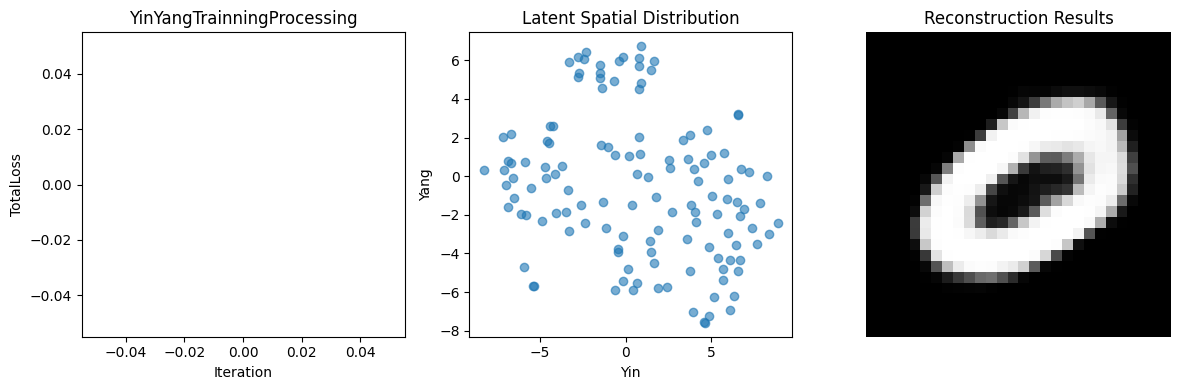

In [ ]:

# 可视化结果（执大象，天下往）
plt.figure(figsize=(12, 4))

# 损失曲线
plt.subplot(1, 3, 1)
plt.plot(loss_history)
plt.title("YinYangTrainningProcessing")
plt.xlabel("Iteration")
plt.ylabel("TotalLoss")

# 潜在空间可视化
with torch.no_grad():
    sample_data, _ = next(iter(train_loader))
    _, z = model(sample_data.view(-1, 784))
    z_tsne = TSNE(n_components=2).fit_transform(z.numpy())

plt.subplot(1, 3, 2)
plt.scatter(z_tsne[:,0], z_tsne[:,1], alpha=0.6)
plt.title("Latent Spatial Distribution")
plt.xlabel("Yin")
plt.ylabel("Yang")

# 重构示例
plt.subplot(1, 3, 3)
plt.imshow(x_recon[0].detach().cpu().view(28, 28).numpy(), cmap='gray')
plt.title("Reconstruction Results")
plt.axis('off')

plt.tight_layout()
plt.show()